# Edge Classification

### before begin (Homogeneous Graph - Edges classification)

In [10]:
import numpy as np
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import torchmetrics

In [11]:
src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
edge_pred_graph.edata['feature'] = torch.randn(1000, 10)
edge_pred_graph.edata['label'] = torch.randint(0, 2, (1000, 3))
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

In [12]:
edge_pred_graph.edata['label']

tensor([[0, 0, 1],
        [1, 0, 1],
        [1, 0, 1],
        ...,
        [0, 1, 0],
        [0, 1, 1],
        [0, 1, 0]])

In [13]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [14]:
import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            print(graph.ndata['h'][0])
            print(graph.ndata['h'].shape)
            graph.apply_edges(fn.u_mul_v('h', 'h', 'score'))
            print(graph.edata['score'][0])
            print(graph.edata['score'].shape)
            return graph.edata['score']

In [15]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()

    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [16]:
edge_pred_graph

Graph(num_nodes=100, num_edges=1000,
      ndata_schemes={'feature': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'feature': Scheme(shape=(10,), dtype=torch.float32), 'label': Scheme(shape=(3,), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [17]:
edge_pred_graph.ndata['h'].shape

KeyError: 'h'

In [18]:
edge_pred_graph.edata['label'].shape

torch.Size([1000, 3])

In [19]:
edge_pred_graph.nodes()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [20]:
len(edge_pred_graph.edges()[0])

1000

In [21]:
len(edge_pred_graph.edges()[1])

1000

In [22]:
node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']

model = Model(10, 20, 3)

opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    pred = model(edge_pred_graph, node_features)
#     print(pred.shape)
#     print('pred : ', pred)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

tensor([-0.2797, -1.3752, -3.0640], grad_fn=<SelectBackward>)
torch.Size([100, 3])
tensor([0.0072, 0.0274, 1.5548], grad_fn=<SelectBackward>)
torch.Size([1000, 3])
15.871016502380371
tensor([-0.2832, -1.3482, -3.0144], grad_fn=<SelectBackward>)
torch.Size([100, 3])
tensor([0.0060, 0.0400, 1.4951], grad_fn=<SelectBackward>)
torch.Size([1000, 3])
15.048108100891113
tensor([-0.2866, -1.3215, -2.9649], grad_fn=<SelectBackward>)
torch.Size([100, 3])
tensor([0.0049, 0.0523, 1.4367], grad_fn=<SelectBackward>)
torch.Size([1000, 3])
14.267565727233887
tensor([-0.2896, -1.2949, -2.9157], grad_fn=<SelectBackward>)
torch.Size([100, 3])
tensor([0.0039, 0.0648, 1.3795], grad_fn=<SelectBackward>)
torch.Size([1000, 3])
13.526212692260742
tensor([-0.2924, -1.2686, -2.8671], grad_fn=<SelectBackward>)
torch.Size([100, 3])
tensor([0.0030, 0.0775, 1.3235], grad_fn=<SelectBackward>)
torch.Size([1000, 3])
12.823081970214844
tensor([-0.2951, -1.2426, -2.8186], grad_fn=<SelectBackward>)
torch.Size([100, 3])
te

###### pred

In [23]:
edge_label[train_mask].shape

torch.Size([608, 3])

In [24]:
pred[train_mask].shape

torch.Size([608, 3])

In [25]:
edge_label[train_mask]

tensor([[0, 0, 1],
        [1, 0, 1],
        [1, 1, 0],
        ...,
        [0, 0, 1],
        [0, 1, 1],
        [0, 1, 0]])

In [26]:
pred[train_mask]

tensor([[ 3.5534e-04,  1.4165e-01,  1.0666e+00],
        [ 1.1668e-01,  3.2346e+00,  1.1539e+01],
        [ 2.2889e-01, -4.2623e-01,  7.5495e-01],
        ...,
        [ 1.2989e-01, -5.8862e-02,  1.9259e+00],
        [ 1.0248e-01,  4.0739e-01, -2.9927e+00],
        [ 2.3754e+00,  1.4234e-01,  1.1975e+01]], grad_fn=<IndexBackward>)

In [27]:
pred[train_mask] - edge_label[train_mask]

tensor([[ 3.5534e-04,  1.4165e-01,  6.6623e-02],
        [-8.8332e-01,  3.2346e+00,  1.0539e+01],
        [-7.7111e-01, -1.4262e+00,  7.5495e-01],
        ...,
        [ 1.2989e-01, -5.8862e-02,  9.2594e-01],
        [ 1.0248e-01, -5.9261e-01, -3.9927e+00],
        [ 2.3754e+00, -8.5766e-01,  1.1975e+01]], grad_fn=<SubBackward0>)

### inference

In [28]:
edge_pred_graph

Graph(num_nodes=100, num_edges=1000,
      ndata_schemes={'feature': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'feature': Scheme(shape=(10,), dtype=torch.float32), 'label': Scheme(shape=(3,), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})

In [29]:
src_ids = [1, 2, 2, 3, 3, 4, 4, 5]
dst_ids = [2, 1, 3, 2, 4, 3, 5, 4]
g_sub = dgl.graph((src_ids, dst_ids))
g_sub.ndata['feature'] = node_features[:6, :]

In [30]:
model(g_sub, g_sub.ndata['feature'])

tensor([-1.4575, -0.5896, -0.6902], grad_fn=<SelectBackward>)
torch.Size([6, 3])
tensor([ 0.4458, -1.4503,  1.7526], grad_fn=<SelectBackward>)
torch.Size([8, 3])


tensor([[ 0.4458, -1.4503,  1.7526],
        [ 0.4458, -1.4503,  1.7526],
        [ 0.4483, -1.2581,  3.5670],
        [ 0.4483, -1.2581,  3.5670],
        [ 0.8616, -2.6684, -5.8498],
        [ 0.8616, -2.6684, -5.8498],
        [-0.8537, -0.1250, -6.5922],
        [-0.8537, -0.1250, -6.5922]], grad_fn=<GSDDMMBackward>)

In [31]:
pred = torch.argmax(model(g_sub, g_sub.ndata['feature']), axis=1)
pred

tensor([-1.4575, -0.5896, -0.6902], grad_fn=<SelectBackward>)
torch.Size([6, 3])
tensor([ 0.4458, -1.4503,  1.7526], grad_fn=<SelectBackward>)
torch.Size([8, 3])


tensor([2, 2, 2, 2, 0, 0, 1, 1])

----

### Heterogeneous Graph

- 임의로 Heterogeneous Graph 생성
- node : [`user`, `item`]
- edges : 
    - user-user : `follow`, `followed-by`
    - user-item : `click`, `dislike`
    - item-user : `clicked-by`, `disliked-by`
- n_users : 1000 users
- n_items : 500 items
- features : 10 type of features
- user_classes : 5 type of users


In [70]:

# test_n_users = 100
# test_n_items = 500
# test_n_follows = 1000
# test_n_clicks = 2000
# test_n_dislikes = 300
# test_n_hetero_features = 10
# test_n_user_classes = 3
# test_n_max_clicks = 7

# test_follow_src = np.random.randint(0, test_n_users, test_n_follows)
# test_follow_dst = np.random.randint(0, test_n_users, test_n_follows)
# test_click_src = np.random.randint(0, test_n_users, test_n_clicks)
# test_click_dst = np.random.randint(0, test_n_items, test_n_clicks)
# test_dislike_src = np.random.randint(0, test_n_users, test_n_dislikes)
# test_dislike_dst = np.random.randint(0, test_n_items, test_n_dislikes)

# test_hetero_graph = dgl.heterograph({
#     ('user', 'follow', 'user'): (test_follow_src, test_follow_dst),
#     ('user', 'followed-by', 'user'): (test_follow_dst, test_follow_src),
#     ('user', 'click', 'item'): (test_click_src, test_clicbk_dst),
#     ('item', 'clicked-by', 'user'): (test_click_dst, test_click_src),
#     ('user', 'dislike', 'item'): (test_dislike_src, test_dislike_dst),
#     ('item', 'disliked-by', 'user'): (test_dislike_dst, test_dislike_src)})

# test_hetero_graph.nodes['user'].data['feature'] = torch.randn(test_n_users, test_n_hetero_features)
# test_hetero_graph.nodes['item'].data['feature'] = torch.randn(test_n_items, test_n_hetero_features)
# test_hetero_graph.nodes['user'].data['label'] = torch.randint(0, test_n_user_classes, (test_n_users,))
# test_hetero_graph.edges['click'].data['label'] = torch.randint(1, test_n_max_clicks, (test_n_clicks,)).float()

# test_edge_label = test_dec_graph.edata[dgl.ETYPE]

In [71]:
import numpy as np
import torch

n_users = 1000
n_items = 500
n_follows = 3000
n_clicks = 5000
n_dislikes = 500
n_hetero_features = 10
n_user_classes = 5
n_max_clicks = 10

follow_src = np.random.randint(0, n_users, n_follows)
follow_dst = np.random.randint(0, n_users, n_follows)
click_src = np.random.randint(0, n_users, n_clicks)
click_dst = np.random.randint(0, n_items, n_clicks)
dislike_src = np.random.randint(0, n_users, n_dislikes)
dislike_dst = np.random.randint(0, n_items, n_dislikes)

hetero_graph = dgl.heterograph({
    ('user', 'follow', 'user'): (follow_src, follow_dst),
    ('user', 'followed-by', 'user'): (follow_dst, follow_src),
    ('user', 'click', 'item'): (click_src, click_dst),
    ('item', 'clicked-by', 'user'): (click_dst, click_src),
    ('user', 'dislike', 'item'): (dislike_src, dislike_dst),
    ('item', 'disliked-by', 'user'): (dislike_dst, dislike_src)})

hetero_graph.nodes['user'].data['feature'] = torch.randn(n_users, n_hetero_features)
hetero_graph.nodes['item'].data['feature'] = torch.randn(n_items, n_hetero_features)
hetero_graph.nodes['user'].data['label'] = torch.randint(0, n_user_classes, (n_users,))
hetero_graph.edges['click'].data['label'] = torch.randint(1, n_max_clicks, (n_clicks,)).float()

# randomly generate training masks on user nodes and click edges
hetero_graph.nodes['user'].data['train_mask'] = torch.zeros(n_users, dtype=torch.bool).bernoulli(0.6)
hetero_graph.edges['click'].data['train_mask'] = torch.zeros(n_clicks, dtype=torch.bool).bernoulli(0.6)

In [86]:
hetero_graph.edges['click'].data['label']

tensor([6., 9., 1.,  ..., 6., 7., 2.])

In [73]:
type(follow_src)

numpy.ndarray

- node : [`patient`, `drug`, `condition`]
- edge : 
  - (`patient`, `satisfaction`, `drug`) : `label`
  - (`condition`, `symptom`, `patient`)
  - (`drug`, `Effectiveness`, `condition`)
  

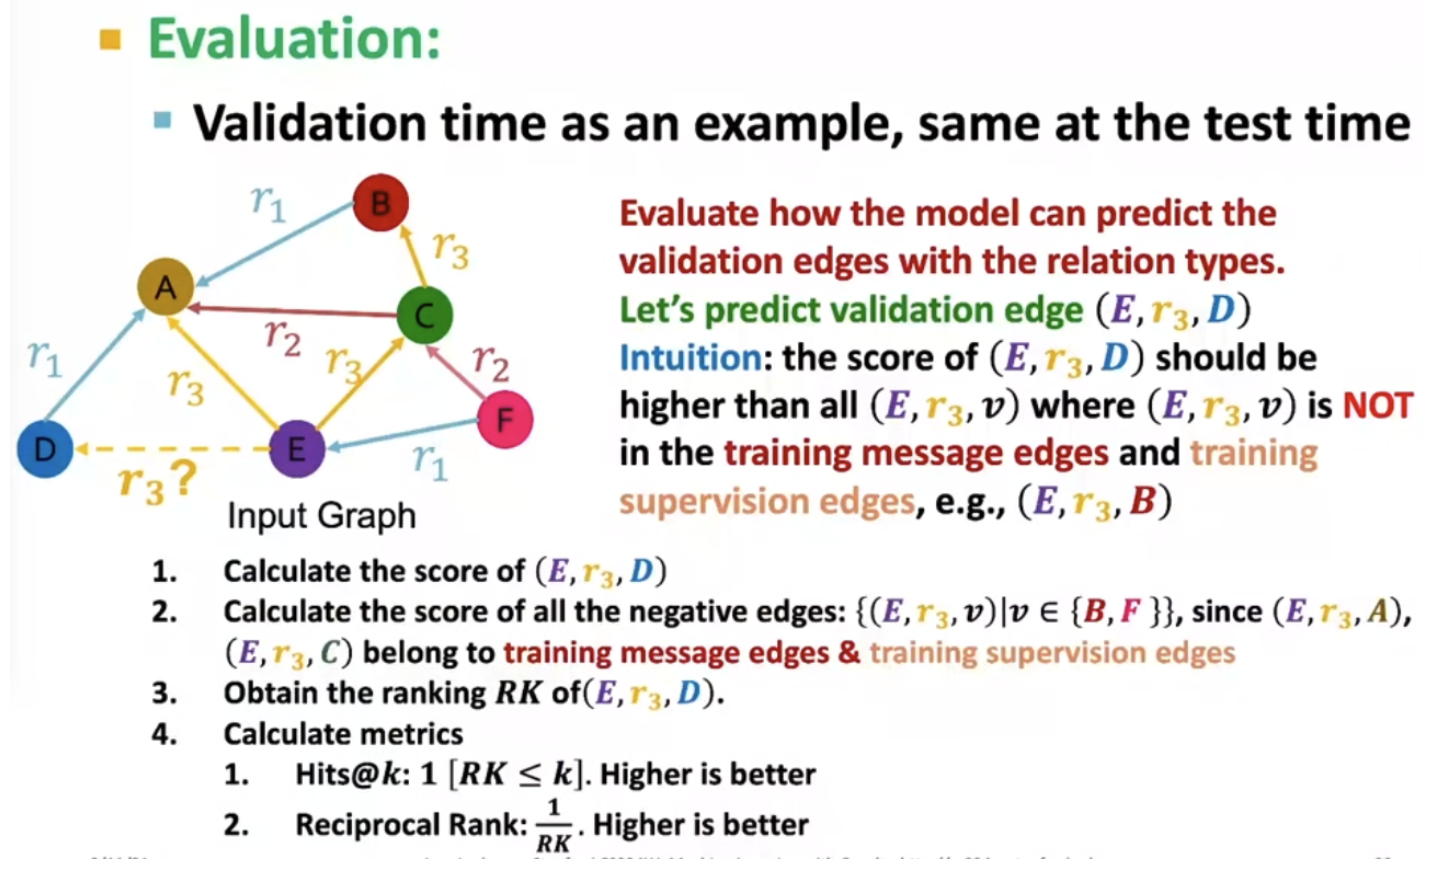

In [34]:
test_follow_src.shape

(1000,)

In [35]:
test_follow_dst.shape

(1000,)

In [37]:
test_hetero_graph.nodes['user']

NameError: name 'test_hetero_graph' is not defined

In [38]:
follow_src.shape

(3000,)

In [39]:
hetero_graph.nodes['item']

NodeSpace(data={'feature': tensor([[-0.1321, -0.0245,  1.3432,  ...,  1.0175,  0.8018,  1.4206],
        [ 0.7287,  0.4188,  0.1242,  ..., -0.2893,  0.2933,  0.3768],
        [ 0.5770, -1.7876, -0.7679,  ..., -0.9118, -0.1458, -0.1805],
        ...,
        [-0.2834,  0.1361, -0.6037,  ..., -1.1721,  0.2587,  3.2572],
        [ 0.9628, -0.2818, -0.6858,  ..., -1.8242, -0.5444,  1.7905],
        [ 0.4390, -0.2516, -0.0768,  ...,  0.5856, -2.0311,  0.2712]])})

- extract only `user` -> `item` edges 

In [40]:
dec_graph = hetero_graph['user', :, 'item']

In [88]:
edge_label = dec_graph.edata[dgl.ETYPE]
print(edge_label)

tensor([2, 2, 2,  ..., 3, 3, 3])


In [87]:
edge_label = dec_graph.edata[dgl.ETYPE]

In [ ]:
e

- `n_click` : 5000 + `n_dislike` : 500 = 5500

In [44]:
hetero_graph.etypes

['clicked-by', 'disliked-by', 'click', 'dislike', 'follow', 'followed-by']

- `model` 변수에는 전체 그래프를 학습에 이용해야하므로 hetero_graph 를 인풋으로 넣어주어야함. \
(단, `logit` 을 이용한 학습 역전파 과정에서는 `dec_graph` 영역만을 이용함)

In [45]:
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
node_features = {'user': user_feats, 'item': item_feats}

opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    logits = model(hetero_graph, node_features, dec_graph)
    loss = F.cross_entropy(logits, edge_label)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

NameError: name 'RGCN' is not defined

In [274]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

In [46]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')


    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [48]:
class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__()
        self.W = nn.Linear(in_dims * 2, n_classes)

    def apply_edges(self, edges):
        x = torch.cat([edges.src['h'], edges.dst['h']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [79]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        
        self.pred = HeteroMLPPredictor(out_features, len(rel_names))

        
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
        print(h['item'].shape)
        print(h['user'].shape)
        return self.pred(dec_graph, h)

### Masking Task

In [80]:
train_mask = torch.zeros(5500, dtype=torch.bool).bernoulli(0.6)
val_mask = ~train_mask

In [81]:
user_feats

tensor([[-2.0578, -0.4036, -0.1274,  ...,  1.9911, -0.7597,  0.9809],
        [ 1.3353, -1.2906, -0.6780,  ...,  0.9044, -0.8383, -1.9187],
        [-0.2584, -1.9220,  0.1754,  ...,  0.6926, -0.0744,  0.0608],
        ...,
        [-0.0948,  1.4532,  0.3427,  ..., -0.4902, -0.8763,  0.0056],
        [ 1.2389, -0.2053, -2.1004,  ..., -0.4636, -0.3797,  1.1620],
        [ 1.0978, -0.1407, -0.1434,  ..., -0.6597,  0.8145,  0.0596]])

In [82]:
user_feats[:, :5]

tensor([[-2.0578, -0.4036, -0.1274, -0.2993,  0.4782],
        [ 1.3353, -1.2906, -0.6780,  0.4017, -0.4769],
        [-0.2584, -1.9220,  0.1754, -0.2008, -1.6437],
        ...,
        [-0.0948,  1.4532,  0.3427,  0.3923, -0.4020],
        [ 1.2389, -0.2053, -2.1004,  0.9384,  0.1731],
        [ 1.0978, -0.1407, -0.1434, -0.9515,  0.1859]])

In [84]:
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
node_features = {'user': user_feats, 'item': item_feats}

opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
    logits = model(hetero_graph, node_features, dec_graph)
    print('logits')
    print(logits.shape)
    loss = F.cross_entropy(logits[train_mask], edge_label[train_mask])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

    acc_train = torchmetrics.functional.accuracy(logits[train_mask], edge_label[train_mask])
    print('train_acc : ', acc_train)

torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.4018373489379883
train_acc :  tensor(0.0159)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.3645639419555664
train_acc :  tensor(0.0153)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.3282415866851807
train_acc :  tensor(0.0146)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.292813539505005
train_acc :  tensor(0.0143)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.2582573890686035
train_acc :  tensor(0.0137)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.2245535850524902
train_acc :  tensor(0.0125)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.1916663646698
train_acc :  tensor(0.0134)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
torch.Size([5500, 6])
2.159557580947876
train_acc :  tensor(0.0146)
torch.Size([500, 5])
torch.Size([1000, 5])
logits
tor

In [85]:
val_mask==True

tensor([False,  True, False,  ..., False, False,  True])

In [66]:
edge_label[val_mask]

tensor([2, 2, 2,  ..., 3, 3, 3])

In [67]:
acc = torchmetrics.functional.accuracy(logits[val_mask], edge_label[val_mask])
print(acc)

tensor(0.8502)


In [68]:
test_user_feats = test_hetero_graph.nodes['user'].data['feature']
test_item_feats = test_hetero_graph.nodes['item'].data['feature']
test_node_features = {'user': test_user_feats, 'item': test_item_feats}

NameError: name 'test_hetero_graph' is not defined

In [69]:
test_dec_graph = test_hetero_graph['user', :, 'item']

NameError: name 'test_hetero_graph' is not defined

In [397]:
test_dec_graph

Graph(num_nodes={'user': 100, 'item': 500},
      num_edges={('user', 'click+dislike', 'item'): 2300},
      metagraph=[('user', 'item', 'click+dislike')])

In [401]:
test_logits = model(test_hetero_graph, test_node_features, test_dec_graph)

test_acc = torchmetrics.functional.accuracy(test_logits, test_edge_label)
print('test_acc : ', test_acc)

test_acc :  tensor(0.6961)


In [402]:
test_logits

tensor([[ 0.7553, -0.9416,  0.4445, -0.0794, -1.1220, -0.2646],
        [ 0.2239, -0.5436,  0.3723, -0.1483, -0.8618, -0.2410],
        [-0.0309, -0.4829,  0.3007, -0.2497, -0.3313, -0.0023],
        ...,
        [ 0.1637, -0.2771,  0.3252, -0.0625, -0.9946, -0.3035],
        [ 0.2741, -0.4736,  0.4438, -0.5779, -0.8946, -0.4242],
        [ 0.5064, -0.7473,  0.6113, -0.1593, -1.0923, -0.4413]],
       grad_fn=<AddmmBackward>)

In [404]:
test_edge_label

tensor([2, 2, 2,  ..., 3, 3, 3])

### summary
- node 에 대한 class 를 따로 안넣어주는 이유는 node embedding을 통해 나온 값들을 concat 을 통해 edge 예측에 활용하는 것
- node classification 일 경우는 concat 이 아닌 dot 을 이용할 수 있음.
- node 가 어떤 것인지(ex, `user` or `item`)는 `node_feature` 를 입력할 때 구분해서 넣어주므로 자동으로 구분됨


- 만약 노드가 `patient` - `drug` 인 경우에 사용 가능 여부를 `edge` 로 정의해 (ex, `적합`, `부적합`) 사용할 수 있을 것